In [1]:
%pip install torch numpy pandas matplotlib pytorch-lightning librosa --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import typing

# Project Overview and Motivation

### Modeling Effects Pedals

Since the 1950s, guitarists and other instrumentalists have used effects pedals to achieve certain sounds from their instruments, from overdrive and distortion to reverb and delay. These effects are often encapsulated in physical pedals, each one with different analog circuitry, down to the types of capacitors that go on the pedals, to achieve these different sounds. Musicians will then use these pedals downstream of their instrument signal to apply the effect.

Here is a common signal flow for an overdrive pedal with a guitar:

![signal flow](images/signal-flow.png "Signal Flow")

The guitar produces an input signal, which goes through the overdrive pedal, applying the overdriven effect (a sound that is more distorted and louder) on the raw signal, which then goes through the amplifier, which applies its own sound, and outputs it over its speakers.

### Creating An Effects Pedal Model

Now, the goal of this project is to use machine learning to replace the pedal in the signal chain with software -- a model that emulates the same sound that musicians come to expect when using that pedal.

![signal flow in software](images/signal-flow-sw.png "Signal Flow in Software")

Using an input waveform from the guitar, and an output waveform from the guitar pedal, we can perform supervised learning to achieve this pedal model, completely cutting out the physical pedal in the signal chain altogether!

### Our Setup

For this project, we wanted to model a Boss DS-2 Turbo Distortion Pedal. To achieve this setup and record our dataset, we split the output of the guitar -- one side goes into an input of an audio interface so we can record the raw guitar signal, and the other goes to the pedal, the output of which goes to another input of the audio interface so we can record the distorted guitar signal.


## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this task. What we are essentially doing here is reading from our .wav files and plotting that data on a graph which depicts the amplitude of the wave over time.

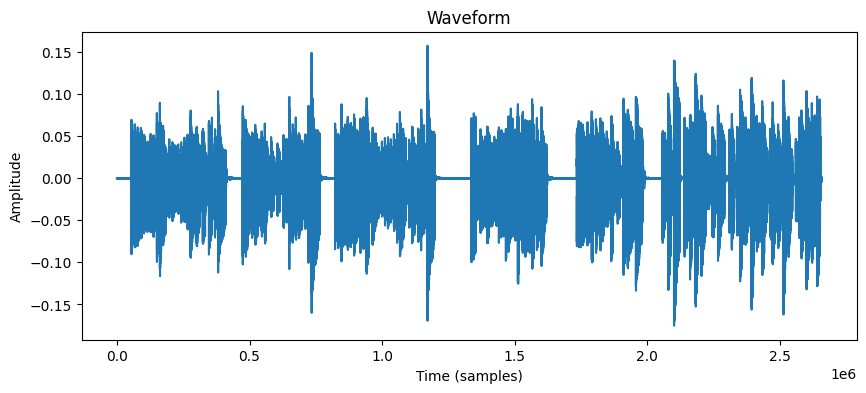

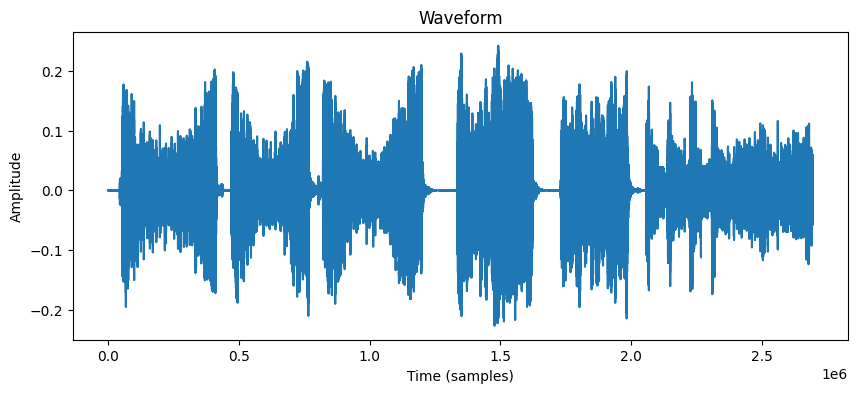

In [3]:
# data exploration to expand on later

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input_Shortened.wav")
out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output_Shortened.wav")

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

### Analysis
as can be seen here, the graph for input and output datasets differ drastically

# Machine Learning
We are planning on using a neural network for our machine learning model. 

In [16]:
# turn into tensors for torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=float).unsqueeze(1)

inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

Input Tensor Shape: torch.Size([2656193, 1])
Target Tensor Shape: torch.Size([2693520, 1])


## Neural Network
WaveNet is our initial neural network for this project. There are five layers in this model, and we will explain our reasoning for using these five layers shortly
1. Input Layer
    - this is our input layer that takes in our raw audio signal and converts it via a 1x1 convolution, which transforms a single-channel raw waveform into multiple feature maps. Feature maps are the output of the 1x1 convolution that lets the model decide which features actually matter (pitch, amplitude, etc.). This makes it so that we do not have to manually select our features, which, due to the vast domain of audio, could lead our model to be overfitted.
2. Dilated Convolution Layers:
3. Residual Connections
4. Skip Connections
5. Output Layer


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        padding = dilation * (kernel_size - 1)
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation, padding=padding
        )
        self.skip_conv = nn.Conv1d(out_channels, out_channels, 1)
        self.residual_conv = nn.Conv1d(out_channels, in_channels, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.dilated_conv(x)
        skip = self.skip_conv(out)
        residual = self.residual_conv(out)
        out = self.activation(out + skip)  # Add residual + skip, then apply activation
        return out, residual


class WaveNet(nn.Module):
    def __init__(
        self,
        num_channels: int = 32,
        dilation_depth: int = 4,
        kernel_size: int = 2,
        num_classes: int = 256,
    ):
        super(WaveNet, self).__init__()
        self.input_layer = nn.Conv1d(
            in_channels=1, out_channels=num_channels, kernel_size=1
        )

        self.residual_blocks = nn.ModuleList()
        dilation = 1
        for i in range(dilation_depth):
            self.residual_blocks.append(
                ResidualBlock(num_channels, num_channels, kernel_size, dilation)
            )
            dilation *= 2  # Double the dilation at each block

        self.output_layer = nn.Conv1d(num_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        skip_connections = []
        for block in self.residual_blocks:
            out, skip = block(out)
            # skip_connections.append(skip)

            # # Ensure the skip connections have the same shape
            # out = sum(skip_connections)  # Sum over the skip connections
        out = self.output_layer(out)
        return out

In [6]:
# training loop

# class for pytorch 
class Audio(Dataset):
    def __init__(self, inputs: Tensor, outputs: Tensor):
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, index: int) -> tuple:
        return self.inputs[index], self.outputs[index]

batch_size = 128
learning_rate = 0.001
num_epochs = 10

num_channels = 32
dilation_depth = 4
kernel_size = 2
num_classes = 2 ** 8

model = WaveNet(num_channels, dilation_depth, kernel_size, num_classes)

training_dataset = Audio(inp_tensor, out_tensor)
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_model(model: nn.Module, dataLoader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int = 10) -> None:
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in dataLoader:
            optimizer.zero_grad()

            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)

            outputs = model(inputs.float())

            loss = criterion(outputs.float(), targets.float())

            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")


train_model(model, train_loader, criterion, optimizer, num_epochs)


/Users/shim/Documents/Programming/ml/project/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/shim/Documents/Programming/ml/project/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([65, 1, 1])) that is different to the input size (torch.Size([65, 1, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 0.0017432533204555511
Epoch: 2, Loss: 0.0027142493054270744
Epoch: 3, Loss: 0.0018339515663683414
Epoch: 4, Loss: 0.0026774911675602198
Epoch: 5, Loss: 0.001514624455012381
Epoch: 6, Loss: 0.0032730947714298964
Epoch: 7, Loss: 0.0025519158225506544
Epoch: 8, Loss: 0.0015198829350993037
Epoch: 9, Loss: 0.0015342185506597161
Epoch: 10, Loss: 0.0013638922246173024


In [7]:
torch.save(model.state_dict(), "wavenet_guitar_model.pth")
print("Model saved successfully.")

Model saved successfully.


In [8]:
model = WaveNet()  # Ensure this matches the architecture used during training

# Load the saved state dictionary
model.load_state_dict(torch.load("wavenet_guitar_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


/var/folders/d2/675lrzyj6cj_fpwyn4y9zr7m0000gn/T/ipykernel_10811/76303354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("wavenet_guita

In [19]:
new_audio_signal, new_sampling_rate = load_audio("./data/ML_Pedal_Input.wav")

# Ensure input tensor has the correct type (float32)
new_audio_signal = to_tensor(new_audio_signal).float()

# Reshape to (1, 1, sequence_length) for Conv1d
new_audio_signal = new_audio_signal.unsqueeze(0).transpose(1, 2)

print(new_audio_signal.shape)  # Verify the shape is (1, 1, sequence_length)

# Perform inference
with torch.no_grad():
    output = model(new_audio_signal)

# Post-process the output
output_signal = output.squeeze().numpy()  # Remove extra dimensions


torch.Size([1, 1, 19189780])


In [10]:
%pip install soundfile


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import soundfile as sf
import librosa

print(inp_audio_signal.shape)
print(output_signal.shape)

# Normalize the signal to [-1, 1] (optional but recommended for audio files)
output_signal = output_signal / np.max(np.abs(output_signal))

# Set sample rate
sample_rate = 44100  # Replace with the actual sample rate of your audio

# Save using librosa + soundfile
sf.write("output_signal.wav", output_signal, sample_rate)
print("Output saved as 'output_signal.wav'")

(2656193,)
(19189795,)
Output saved as 'output_signal.wav'
